In [1]:
from framework_pkg.framework import FrameWork

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interpolate
from cobaya.run import run

from getdist.mcsamples import MCSamplesFromCobaya
from getdist import plots, MCSamples
import getdist.plots as gdplt

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['text.usetex']=True
plt.style.use('classic')


Warning!: Python module pyslha not found, disabling slha reading routines


In [2]:
param ={'SinT12'  : 0.310 ,
        'T13'  : 8.57, 
        'mu1'  : 0.,
        'mu2'  : 0., 
        'mu3'  : 0.  ,
        'mdm'  : 1.089e-3 , 
        'alpha': 0.  ,
        'eps' : 0.  ,
        'alpha_eps' : 0.  ,
        'M12'  : 6.9e-5 }

# #add='./Data/time_exposures.txt',
# frame_total  = FrameWork(threshold=3.5,
#                             efficiency_correction=True,
#                             resolution_correction=False,
#                                    )


# data_day = 2.284
# error_day = np.sqrt(0.020**2 + 0.032**2)

# data_night = 2.341
# error_night = np.sqrt(0.019**2 + 0.033**2)


# T_day = frame_total.time_day[:,2]
# T_night = frame_total.time_day[:,3]

# sigma_p = 0.014
# #delta_p = 0.54

# def LogLikelihood(sint12, m12, mu2, eps, delta_p):
#     param['SinT12'] = sint12
#     param['M12'] = m12 * 1e-5

#     param['mu2'] = mu2
#     param['alpha'] = 0.73
#     param['eps'] = eps
#     param['alpha_eps'] = 2.24

#     param['mdm'] = 0.84 * 2e-4

#     predicted_total_signal = frame_total.__getitem__(param) 
#     R_day = (1 / np.sum(T_day)) * np.sum(5.25 * T_day * predicted_total_signal['period0'][:,0])
#     R_night = (1 / np.sum(T_night)) * np.sum(5.25 * T_night * predicted_total_signal['period1'][:,0])

#     predict_day = R_day * ( 1 - delta_p * sigma_p)
#     predict_night = R_night * ( 1 - delta_p * sigma_p)

#     return -0.5 * ( (predict_day - data_day)**2/error_day**2 + (predict_night - data_night)**2/error_night**2 + delta_p**2 ) 

In [3]:
frame_spectrum  = FrameWork(threshold=3.5,
                            efficiency_correction=False,
                            resolution_correction=True,
                                   )

spectrum_data = frame_spectrum.spectrum_data
energy_obs    = frame_spectrum.energy_obs

data_dn = np.loadtxt('./Data/B8_SuperK_DN_2023.txt')

def prediction_prepration(frame_spectrum, param):
    predicted_spectrum = frame_spectrum.__getitem__(param)

    daily_exposure, R_daily = frame_spectrum._result_daily_basis(predicted_spectrum)
    
    periods = frame_spectrum.time_periods
    num_periods = len(periods)
    num_states = frame_spectrum.weight.shape[0]
    num_days = frame_spectrum.time_day.shape[0]

    periods_exposure = np.zeros((num_periods, num_days))
    R_periods = np.zeros((num_periods, num_days, num_states))

    for i in range (num_periods):
        periods_exposure[i] = frame_spectrum.time_day[:,2+i]
        for j in range(num_states):
            R_periods[i,:,j] = predicted_spectrum[periods[i]][:,j]


    R_day_daily = R_periods[0]
    R_night_daily = R_periods[1]
    day_exposure = periods_exposure[0]
    night_exposure = periods_exposure[1]

    time_bins = np.array([1])
    prediction = [R_day_daily, R_daily, R_night_daily]
    T_k = [day_exposure, daily_exposure, night_exposure]

    bin_prediction = np.zeros((len(prediction), len(time_bins), num_states))
    for i in range(len(time_bins)):
        cond = frame_spectrum.time_day[:,0] == time_bins[i]
        for k in range (num_states):
            for j in range (len(prediction)):
                bin_prediction[j,i,k] = (1/np.sum(T_k[j][cond])) * np.sum(T_k[j][cond] * prediction[j][cond,k])

    return bin_prediction


def LogLikelihood(sint12, m12, mu2, eps):
    param['SinT12'] = sint12
    param['M12'] = m12 * 1e-5

    param['mu2'] = mu2
    param['alpha'] = 0.73
    param['eps'] = eps
    param['alpha_eps'] = 2.24

    param['mdm'] = 0.84 * 2e-4

    bin_prediction = prediction_prepration(frame_spectrum, param)

    a_symmetry = np.zeros(energy_obs .shape[0])
    for k in range (energy_obs.shape[0]):
        a_symmetry[k] = 2 * (bin_prediction[0,0,k] - bin_prediction[2,0,k]) / (bin_prediction[0,0,k] + bin_prediction[2,0,k])

    chi2 = np.sum((a_symmetry - data_dn[:,2])**2/data_dn[:,3]**2)

    return -0.5 * chi2

In [ ]:
print(LogLikelihood(0.310, 7.51, 0., 0.))

print(LogLikelihood(0.310, 7.51, 0., 0.))

-13.371174231791294


In [5]:
info = {"likelihood": {"Chi2": LogLikelihood},
        
        "params": dict([("sint12" , {"prior" : {"dist": 'norm', "loc": 0.310, "scale" : 0.012},
                                  "latex" : r"\sin(\theta_{12})^2"  
                                  }),

                        
                        ("m12"    , {"prior" : {"dist": 'norm', "loc": 7.51, "scale": 0.19},
                                  "latex": r"\Delta m^2_{21} \ \rm 10^{-5} \ eV^2"  
                                  }), 
                        
                        ("mu2"    , {"prior" : {"min": 0, "max": 0.15},
                                   "latex" : r"\tilde{\mu}^2/2 "  
                                   }),
                        
                        # ("alpha"  , {"prior" : {"min": 0, "max": np.pi},
                        #            "latex" : r"\alpha "  
                        #            }),

                      
                        ("eps"  , {"prior" : {"min": 0, "max": 1.},
                                   "latex" : r"\epsilon "  
                                   })

                        # ("alpha_eps"  , {"prior" : {"min": 0, "max": np.pi},
                        #            "latex" : r"\alpha_\epsilon "  
                        #            }), 

                        # ("delta_p", {"prior" : {"min": -3, "max": 3},
                        #           "latex": r"\delta_p"  
                        #           }) 

                        # ("mdm", {"prior" : {"min": 1, "max": 10},
                        #            "latex": r"m_{\rm dm}"  
                        #           }) 
                        
                        ]),
        
        "sampler": {"mcmc": {"Rminus1_stop": 0.01, "max_tries": 100000 }},
        "output" : "output10/run_info"
       }

In [7]:
#updated_info,sampler = run(info)

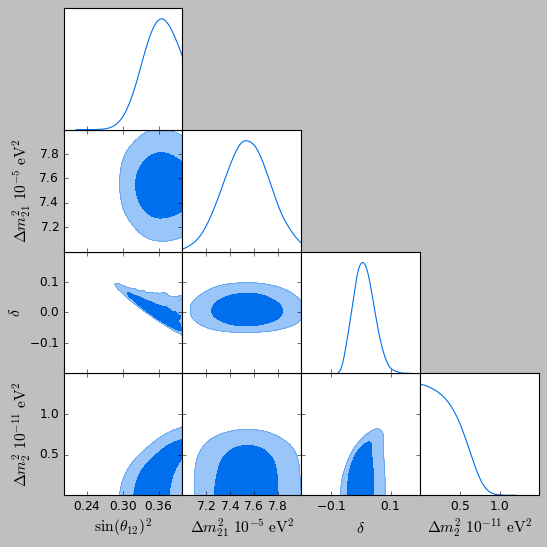

In [10]:
# Filled 2D comparison plot with legend
gd_sample = MCSamplesFromCobaya(updated_info, sampler.products()["sample"])

gdplot = gdplt.get_subplot_plotter(width_inch=7)

gdplot.settings.scaling = False
gdplot.triangle_plot(gd_sample, ["t12","m12","delta","mum2"], filled=True, 
                     param_limits={'t12': (0.28, 0.36), 
                                   'm12': (7, 8),
                                   'delta': (-0.2, 0.2),
                                   'mum2': (0, 1.5)
                                  },lw=2)

#gdplot.export('./bayes_1_nopriors.pdf')

In [ ]:
#best fit and covariance matrix and errors
mean   = gd_sample.getMeans()
covmat = gd_sample.getCovMat().matrix[:, :]
print("Mean:")
print(mean)
print("Covariance matrix:")
print(covmat)
print('####################')

stats = gd_sample.getMargeStats()
lims1 = stats.parWithName('t12').limits
lims2 = stats.parWithName('mum2').limits
lims3 = stats.parWithName('m12').limits
lims4 = stats.parWithName('delta').limits

for conf, lim1, lim2, lim3, lim4 in zip(gd_sample.contours, lims1,lims2,lims3,lims4):
    print('t12 %s%% lower: %.1f upper: %.1f (%s)'%(conf, lim1.lower, lim1.upper, lim1.limitType()))
    print('mum2 %s%% lower: %.2f upper: %.2f (%s)'%(conf, lim2.lower, lim2.upper, lim2.limitType()))
    print('m12 %s%% lower: %.2f upper: %.2f (%s)'%(conf, lim3.lower, lim3.upper, lim3.limitType()))
    print('delta %s%% lower: %.2f upper: %.2f (%s)'%(conf, lim3.lower, lim3.upper, lim3.limitType()))
    print('####################')

In [20]:
logp3 = -np.log(6)-np.log(0.15)-np.log(1)
print(logp3)

0.10536051565782634


In [22]:
logp1 = - 0.5 * (0.310 - 0.294)**2/0.012**2 - np.log(0.012*2.51)
logp2 = - 0.5 * (7.51 - 7.42)**2/0.19**2 -np.log(0.19*np.sqrt(2 * np.pi))
print(logp1,logp2)
print( logp1 + logp2 + logp3 )

2.6136769871615537 0.629604307966009
3.3486418107853893
